In [1]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import dateutil.rrule as rrule
import matplotlib.dates as mdates
import matplotlib
import math
import statsmodels.api as sm
import re
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action='ignore', category=FutureWarning)

In [1]:
PATH = '\\WroData\\20231119 Zanieczyszczenie powietrza'
OUT_PATH =  f"{PATH}\\CHARTS\\"

In [3]:
DIC_NORMA = {
    'NO2_1g': 25,
    'NOx_1g': 25,
    'PM10_1g': 45,
    'PM2.5_1g': 15,
    'SO2_1g': 40,
}
DIC_NORMA_roczna = {
    'NO2_1g': 10,
    'NOx_1g': 10,
    'PM10_1g': 15,
    'PM2.5_1g': 5,
    'SO2_1g': np.nan,
}


In [4]:
ZANIECZYSZCZENIE_LIST = ['NO2_1g', 'NOx_1g', 'PM10_1g', 'PM2.5_1g', 'SO2_1g']
STACJA_LIST = ['DsWrocBartni', 'DsWrocWybCon', 'DsWrocAlWisn']

# wczytanie dancyh

In [5]:
df_ZANIECZYSZCZENIA = pd.read_csv(f'{PATH}\\df_ZANIECZYSZCZENIA.csv')


# obróbka danych

In [6]:
df_ZANIECZYSZCZENIA_grouped_day = df_ZANIECZYSZCZENIA.groupby(['STACJA', 'ZANIECZYSZCZENIE', 'rok', 'miesiac', 'dzien']).agg({
    'Value': np.nanmean,
    'Data': 'count'
    }).reset_index().dropna()

# delete lonly days
df_ZANIECZYSZCZENIA_grouped_day = df_ZANIECZYSZCZENIA_grouped_day.loc[df_ZANIECZYSZCZENIA_grouped_day['Data'] > 1, :]
# drop date column
df_ZANIECZYSZCZENIA_grouped_day = df_ZANIECZYSZCZENIA_grouped_day.drop(columns=['Data'])

df_ZANIECZYSZCZENIA_grouped_day

STACJA ZANIECZYSZCZENIE   rok  miesiac  dzien      Value
0      DsWrocAlWisn           NO2_1g  2005        1      1  38.272727
1      DsWrocAlWisn           NO2_1g  2005        1      2  35.608696
2      DsWrocAlWisn           NO2_1g  2005        1      3  46.043478
3      DsWrocAlWisn           NO2_1g  2005        1      4  45.130435
4      DsWrocAlWisn           NO2_1g  2005        1      5  51.857143
...             ...              ...   ...      ...    ...        ...
57717  DsWrocWybCon           SO2_1g  2022       12     27   4.333161
57718  DsWrocWybCon           SO2_1g  2022       12     28   3.782240
57719  DsWrocWybCon           SO2_1g  2022       12     29   3.089300
57720  DsWrocWybCon           SO2_1g  2022       12     30   3.376417
57721  DsWrocWybCon           SO2_1g  2022       12     31   4.063927

[54249 rows x 6 columns]

In [7]:
df_ZANIECZYSZCZENIA_grouped_year = df_ZANIECZYSZCZENIA.groupby(['STACJA', 'ZANIECZYSZCZENIE', 'rok']).agg({
    'Value': np.nanmean,
    'Data': 'count'
    }).reset_index().dropna()


# delete lonly days
df_ZANIECZYSZCZENIA_grouped_year = df_ZANIECZYSZCZENIA_grouped_year.loc[df_ZANIECZYSZCZENIA_grouped_year['Data'] > 300 * 24, :]
# drop date column
df_ZANIECZYSZCZENIA_grouped_year = df_ZANIECZYSZCZENIA_grouped_year.drop(columns=['Data'])

# show
df_ZANIECZYSZCZENIA_grouped_year

STACJA ZANIECZYSZCZENIE   rok      Value
0    DsWrocAlWisn           NO2_1g  2005  67.547564
1    DsWrocAlWisn           NO2_1g  2006  69.138941
2    DsWrocAlWisn           NO2_1g  2007  60.893431
3    DsWrocAlWisn           NO2_1g  2008  63.500000
5    DsWrocAlWisn           NO2_1g  2010  69.748977
..            ...              ...   ...        ...
171  DsWrocWybCon           SO2_1g  2018   3.789507
172  DsWrocWybCon           SO2_1g  2019   4.036141
173  DsWrocWybCon           SO2_1g  2020   4.254955
174  DsWrocWybCon           SO2_1g  2021   5.240374
175  DsWrocWybCon           SO2_1g  2022   5.259954

[158 rows x 4 columns]

# wizualizacja

## średnia 1-dzienna


DsWrocBartni - NO2_1g


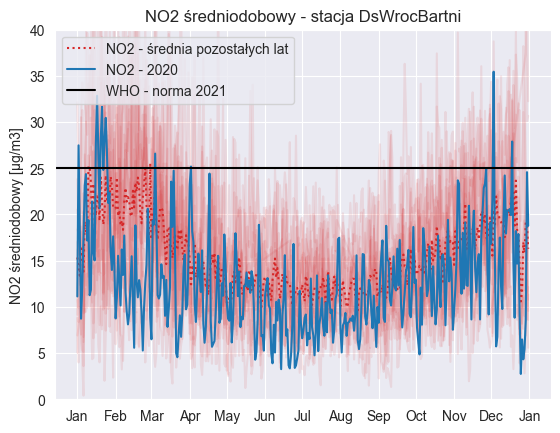

DsWrocBartni - NOx_1g


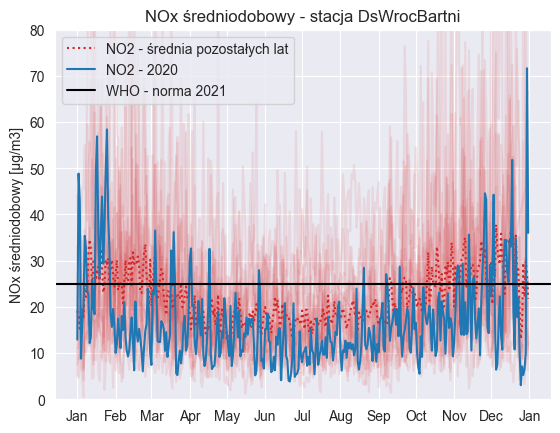

DsWrocBartni - PM10_1g
DsWrocBartni - PM2.5_1g
DsWrocBartni - SO2_1g
DsWrocWybCon - NO2_1g


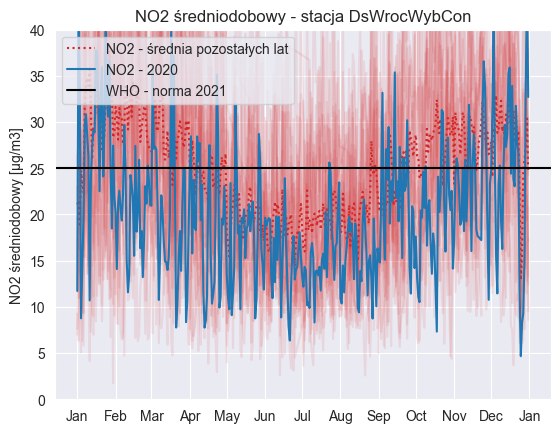

DsWrocWybCon - NOx_1g


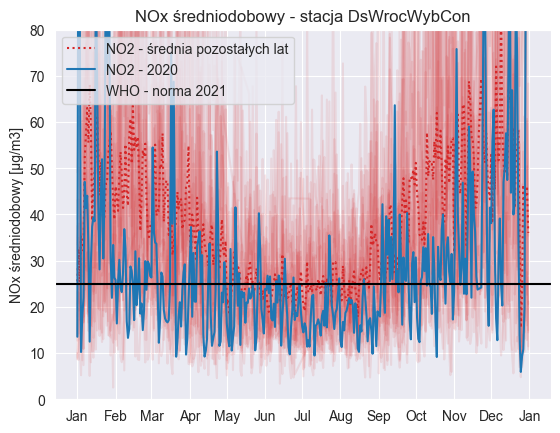

DsWrocWybCon - PM10_1g


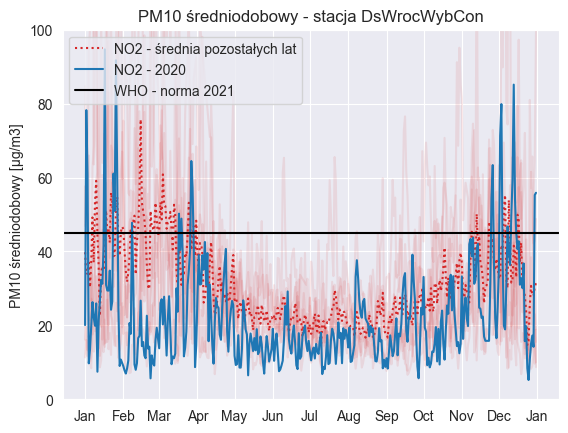

DsWrocWybCon - PM2.5_1g


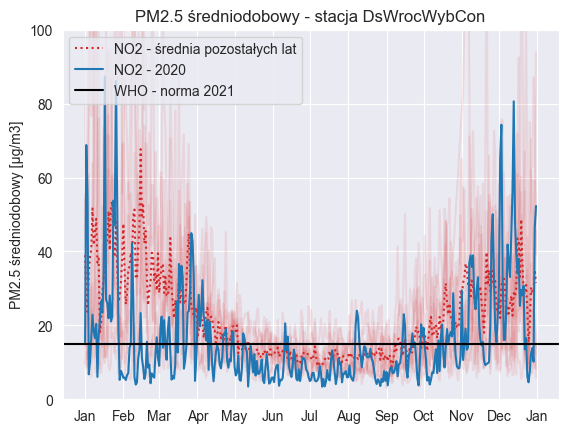

DsWrocWybCon - SO2_1g


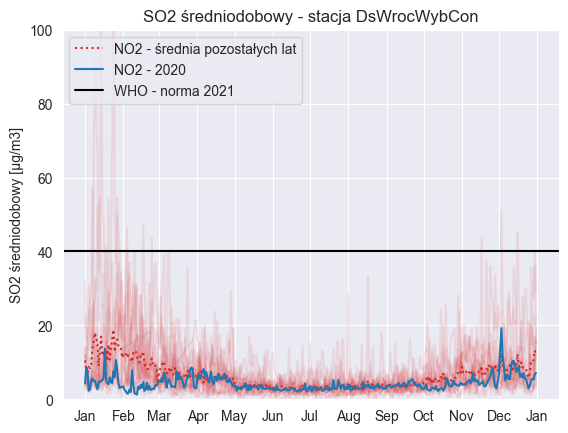

DsWrocAlWisn - NO2_1g


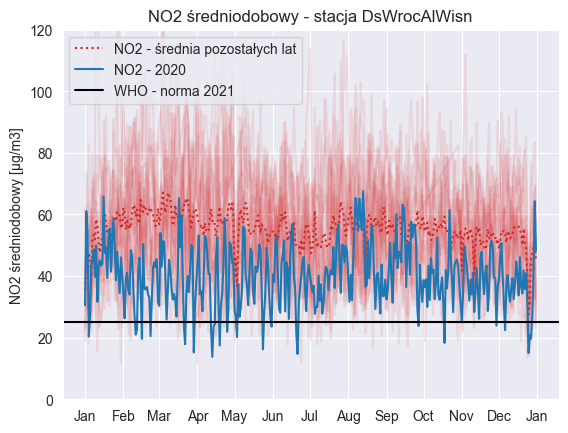

DsWrocAlWisn - NOx_1g


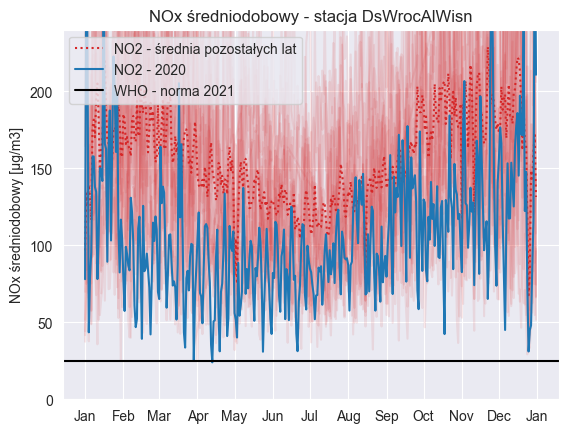

DsWrocAlWisn - PM10_1g
DsWrocAlWisn - PM2.5_1g


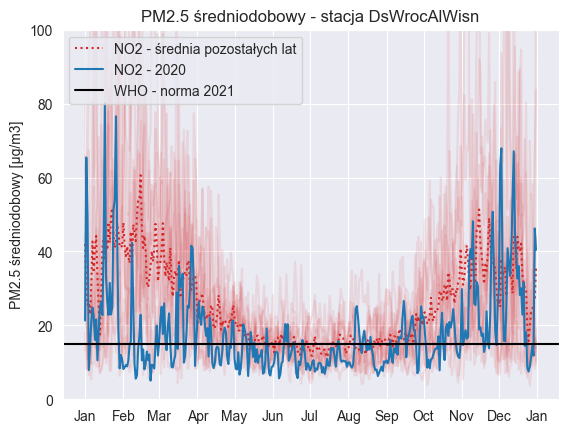

DsWrocAlWisn - SO2_1g


In [8]:
col_stacja = 'DsWrocBartni'
for stacja in STACJA_LIST:
    for wskaznik in ZANIECZYSZCZENIE_LIST:
        print(f'{stacja} - {wskaznik}')

        # select data
        t = df_ZANIECZYSZCZENIA_grouped_day.loc[
            (df_ZANIECZYSZCZENIA_grouped_day['STACJA'] == stacja) &
            (df_ZANIECZYSZCZENIA_grouped_day['ZANIECZYSZCZENIE'] == wskaznik), :]

        # usuń 2023 - tylko 1 ddzień
        t = t.loc[t['rok'] != 2023, :]


        t_2020 = t.loc[t['rok'] == 2020, :]
        t_other = t.loc[t['rok'] != 2020, :]

        if len(t_2020.index) == 0:
            continue

        # oblicz srednią:
        t_avg = (
            t_other
            .dropna(subset = ['Value'])
            .groupby(['miesiac', 'dzien'], dropna=False).agg({
                'Value': np.nanmean,
            }
            )
            .reset_index()
        )
        t_avg['miesiac'] = t_avg['miesiac'].astype(int)
        t_avg['dzien'] = t_avg['dzien'].astype(int)

        # add dates
        t_2020['Date'] = t_2020.apply(lambda x: datetime(2020, x['miesiac'], x['dzien']), axis=1)
        t_other['Date'] = t_other.apply(lambda x: datetime(2020, x['miesiac'], x['dzien']), axis=1)
        t_avg['Date'] = t_avg.apply(lambda x: datetime(int(2020), x['miesiac'].astype(int), x['dzien'].astype(int)), axis=1)

        # plot
        fig, ax1 = plt.subplots()
        color_1 = 'tab:red'
        color_2 = 'tab:blue'
        ax1.set_ylabel(f"{wskaznik.split('_')[0]} średniodobowy [µg/m3]")

        for r in t_other['rok'].unique():
            t_tmp = t_other.loc[t_other['rok'] == r, : ]
            ax1.plot(t_tmp['Date'], t_tmp['Value'],     c = color_1, alpha = 0.1)

        # add lines
        ax1.plot(t_avg['Date'],  t_avg['Value'] , c = color_1, linestyle = ':', label = 'NO2 - średnia pozostałych lat')
        ax1.plot(t_2020['Date'], t_2020['Value'], c = color_2, label = 'NO2 - 2020')

        # add WHO guidline
        ax1.axhline(y=DIC_NORMA[wskaznik], color='black', linestyle='-', label = 'WHO - norma 2021')
        # fix label
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax1.legend(loc = 'upper left')

        title = f"{wskaznik.split('_')[0]} średniodobowy - stacja {stacja}"
        ax1.set_title(title)

        top = 100
        if wskaznik.split('_')[0] == 'NO2':
            top = 40
        elif wskaznik.split('_')[0] == 'NOx':
            top = 80
        elif wskaznik.split('_')[0] == 'PM10':
             plt.ylim(top=60)
        elif wskaznik.split('_')[0] == 'PM2.5':
             plt.ylim(top=60)
        elif wskaznik.split('_')[0] == 'SO2':
             plt.ylim(top=15)

        if (stacja == 'DsWrocAlWisn') & (wskaznik.split('_')[0] != 'PM2.5'):
            top = top * 3

        plt.ylim(top = top, bottom = 0)
        # save plot
        plt.savefig(f"{OUT_PATH}\\{title}.png")

        plt.show()
        plt.close()

## średnia 7-dzienna

DsWrocBartni - NO2_1g


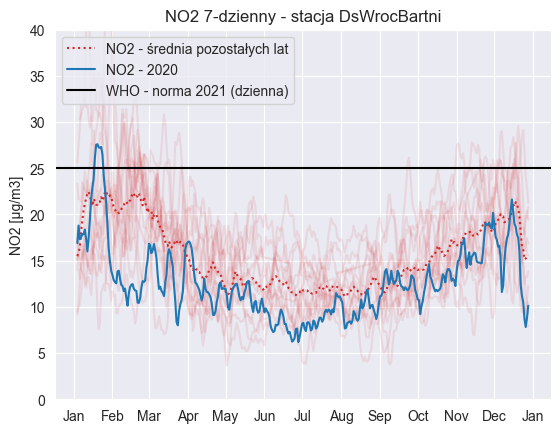

DsWrocBartni - NOx_1g


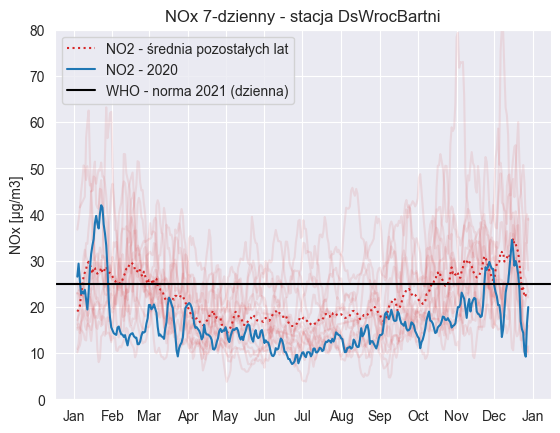

DsWrocBartni - PM10_1g
DsWrocBartni - PM2.5_1g
DsWrocBartni - SO2_1g
DsWrocWybCon - NO2_1g


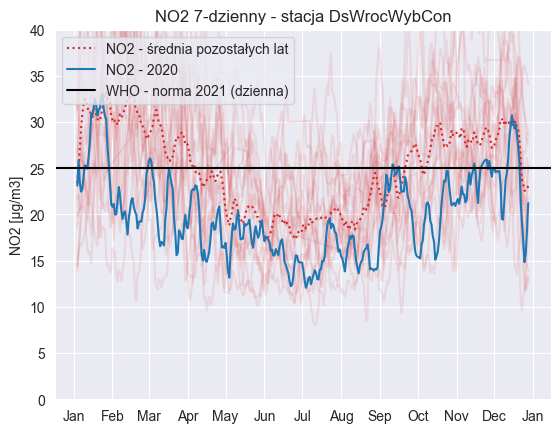

DsWrocWybCon - NOx_1g


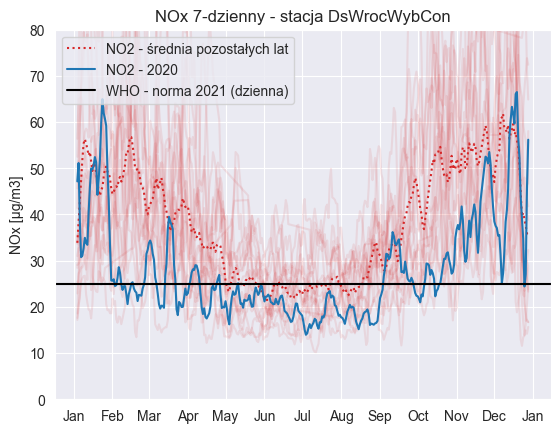

DsWrocWybCon - PM10_1g


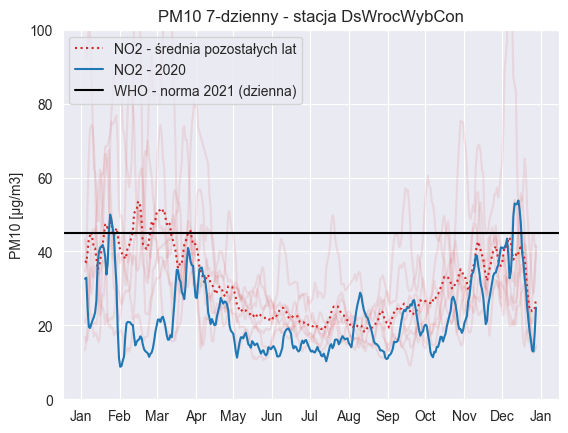

DsWrocWybCon - PM2.5_1g


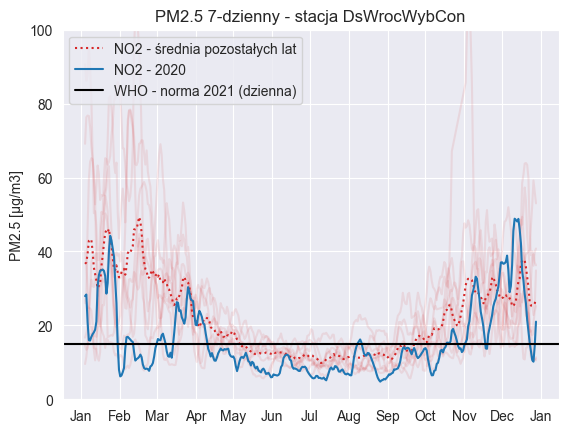

DsWrocWybCon - SO2_1g


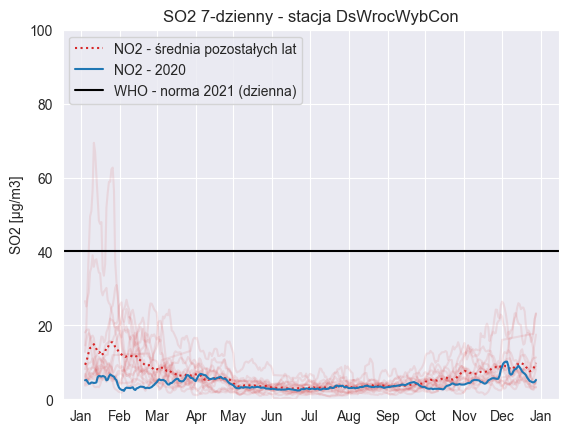

DsWrocAlWisn - NO2_1g


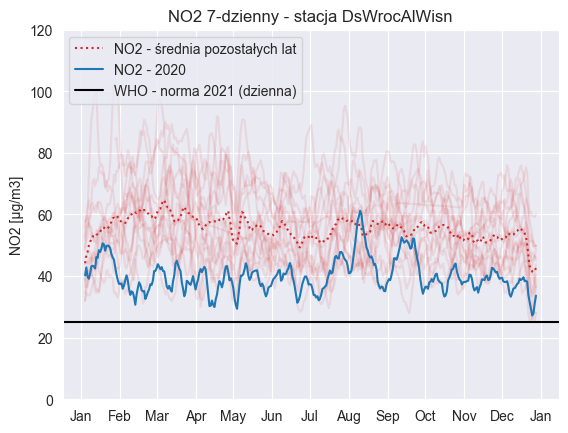

DsWrocAlWisn - NOx_1g


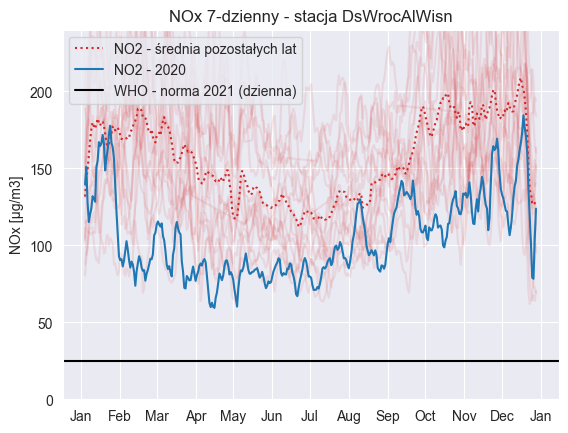

DsWrocAlWisn - PM10_1g
DsWrocAlWisn - PM2.5_1g


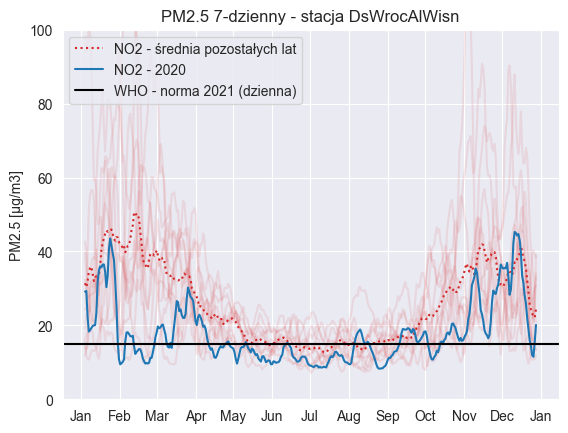

DsWrocAlWisn - SO2_1g


In [9]:
col_stacja = 'DsWrocBartni'
for stacja in STACJA_LIST:
    for wskaznik in ZANIECZYSZCZENIE_LIST:
        print(f'{stacja} - {wskaznik}')

        # select data
        t = df_ZANIECZYSZCZENIA_grouped_day.loc[
            (df_ZANIECZYSZCZENIA_grouped_day['STACJA'] == stacja) &
            (df_ZANIECZYSZCZENIA_grouped_day['ZANIECZYSZCZENIE'] == wskaznik), :]

        # usuń 2023 - tylko 1 ddzień
        t = t.loc[t['rok'] != 2023, :]


        t_2020 = t.loc[t['rok'] == 2020, :]
        t_other = t.loc[t['rok'] != 2020, :]

        if len(t_2020.index) == 0:
            continue

        # oblicz srednią:
        t_avg = (
            t_other
            .dropna(subset = ['Value'])
            .groupby(['miesiac', 'dzien'], dropna=False).agg({
                'Value': np.nanmean,
            }
            )
            .reset_index()
        )
        t_avg['miesiac'] = t_avg['miesiac'].astype(int)
        t_avg['dzien'] = t_avg['dzien'].astype(int)

        # add dates
        t_2020['Date'] = t_2020.apply(lambda x: datetime(2020, x['miesiac'], x['dzien']), axis=1)
        t_other['Date'] = t_other.apply(lambda x: datetime(2020, x['miesiac'], x['dzien']), axis=1)
        t_avg['Date'] = t_avg.apply(lambda x: datetime(int(2020), x['miesiac'].astype(int), x['dzien'].astype(int)), axis=1)

        # plot
        fig, ax1 = plt.subplots()
        color_1 = 'tab:red'
        color_2 = 'tab:blue'
        ax1.set_ylabel(f"{wskaznik.split('_')[0]} [µg/m3]")

        for r in t_other['rok'].unique():
            t_tmp = t_other.loc[t_other['rok'] == r, : ]
            ax1.plot(t_tmp['Date'], t_tmp['Value'].rolling(window=7, center=True).mean(),     c = color_1, alpha = 0.1)

        # add lines
        ax1.plot(t_avg['Date'],  t_avg['Value'].rolling(window=7, center=True).mean() , c = color_1, linestyle = ':', label = 'NO2 - średnia pozostałych lat')
        ax1.plot(t_2020['Date'], t_2020['Value'].rolling(window=7, center=True).mean(), c = color_2, label = 'NO2 - 2020')

        # add WHO guidline
        ax1.axhline(y=DIC_NORMA[wskaznik], color='black', linestyle='-', label = 'WHO - norma 2021 (dzienna)')
        # fix label
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax1.legend(loc = 'upper left')

        title = f"{wskaznik.split('_')[0]} 7-dzienny - stacja {stacja}"
        ax1.set_title(title)

        top = 100
        if wskaznik.split('_')[0] == 'NO2':
            top = 40
        elif wskaznik.split('_')[0] == 'NOx':
            top = 80
        elif wskaznik.split('_')[0] == 'PM10':
             plt.ylim(top=60)
        elif wskaznik.split('_')[0] == 'PM2.5':
             plt.ylim(top=60)
        elif wskaznik.split('_')[0] == 'SO2':
             plt.ylim(top=15)

        if (stacja == 'DsWrocAlWisn') & (wskaznik.split('_')[0] != 'PM2.5'):
            top = top * 3

        plt.ylim(top = top, bottom = 0)
        # save plot
        plt.savefig(f"{OUT_PATH}\\{title}.png")

        plt.show()
        plt.close()

## średnia roczna

DsWrocBartni - NO2_1g


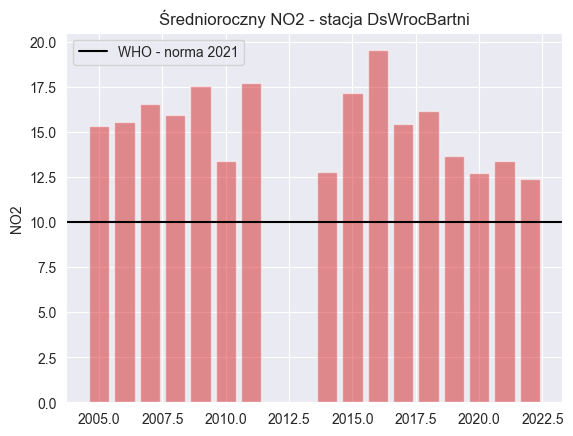

DsWrocBartni - NOx_1g


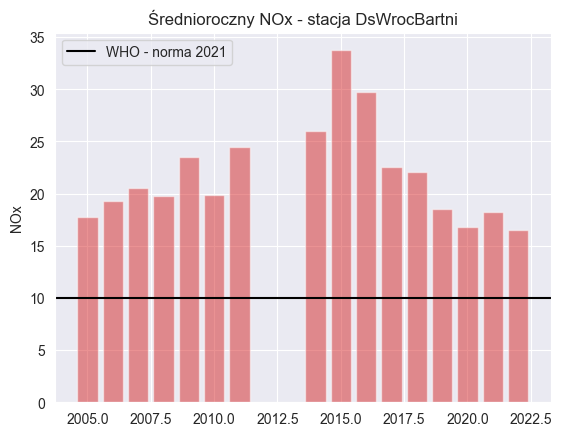

DsWrocBartni - PM10_1g


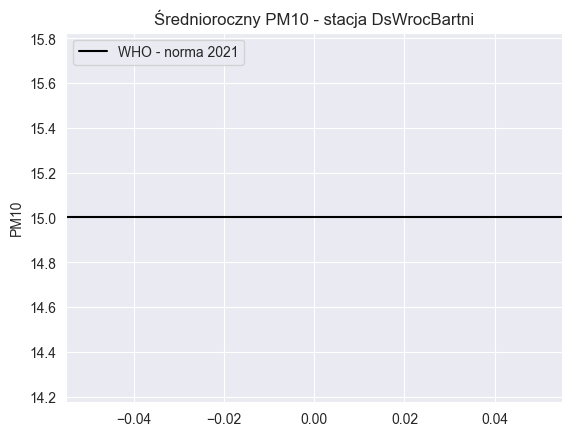

DsWrocBartni - PM2.5_1g


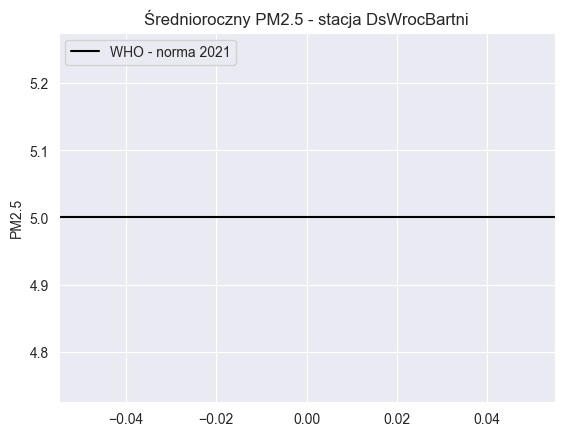

DsWrocBartni - SO2_1g


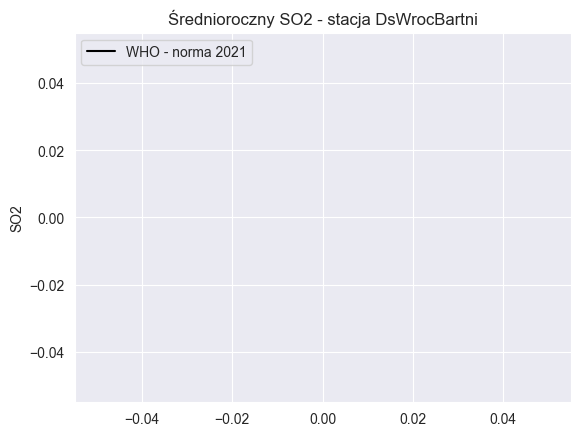

DsWrocWybCon - NO2_1g


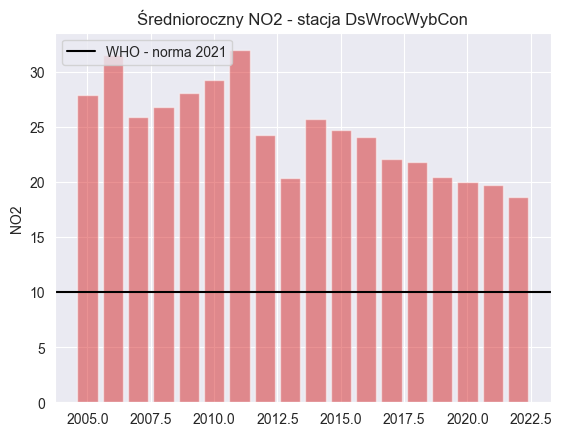

DsWrocWybCon - NOx_1g


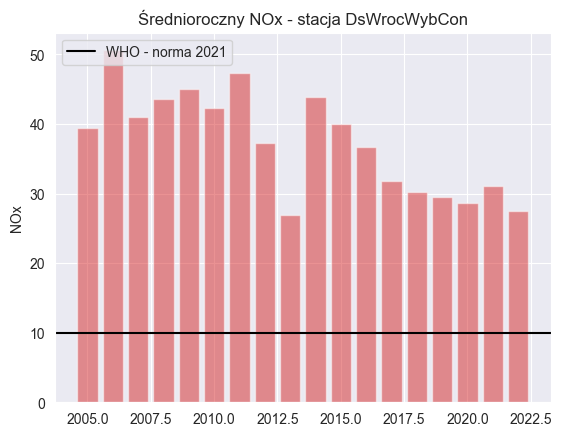

DsWrocWybCon - PM10_1g


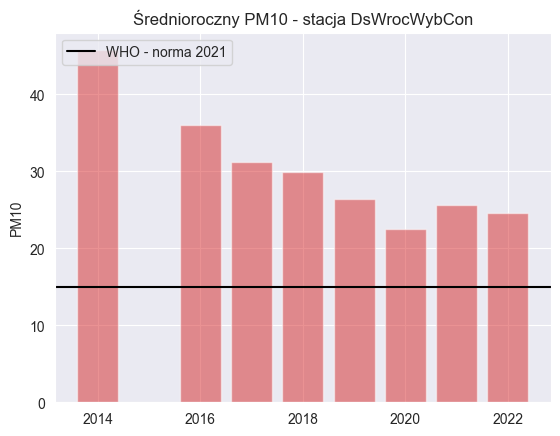

DsWrocWybCon - PM2.5_1g


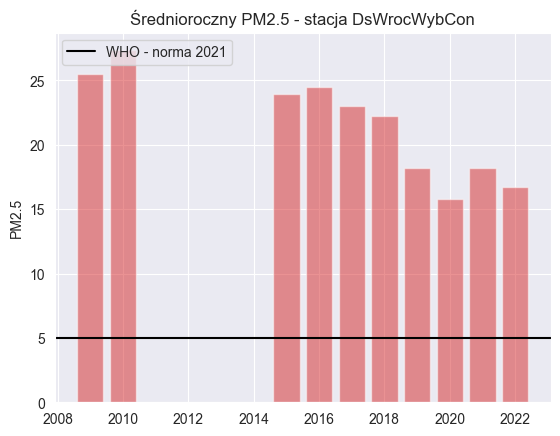

DsWrocWybCon - SO2_1g


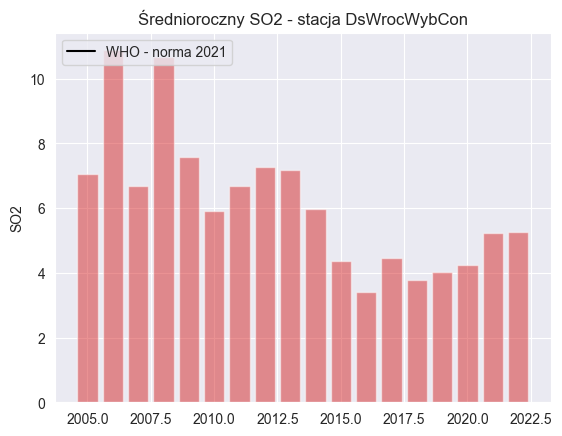

DsWrocAlWisn - NO2_1g


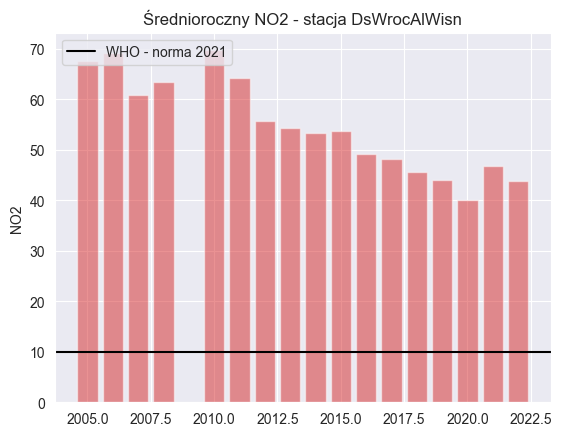

DsWrocAlWisn - NOx_1g


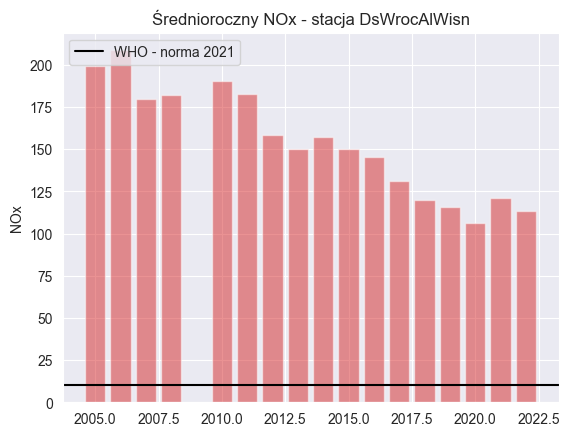

DsWrocAlWisn - PM10_1g


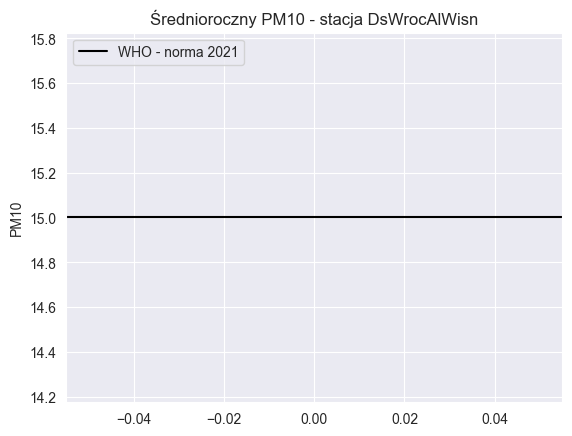

DsWrocAlWisn - PM2.5_1g


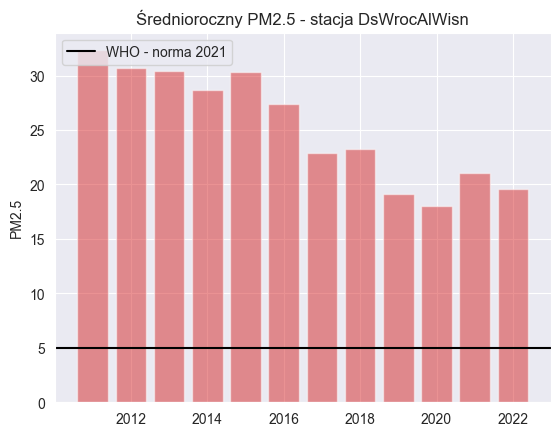

DsWrocAlWisn - SO2_1g


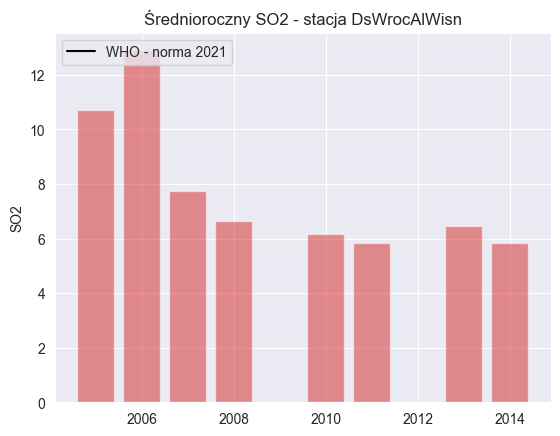

In [10]:

for stacja in STACJA_LIST:
    for wskaznik in ZANIECZYSZCZENIE_LIST:
        print(f'{stacja} - {wskaznik}')

        # select data
        t = df_ZANIECZYSZCZENIA_grouped_year.loc[
            (df_ZANIECZYSZCZENIA_grouped_year['STACJA'] == stacja) &
            (df_ZANIECZYSZCZENIA_grouped_year['ZANIECZYSZCZENIE'] == wskaznik), :]

        # usuń 2023 - tylko 1 ddzień
        t = t.loc[t['rok'] != 2023, :]

        t['Time'] = pd.to_datetime(t['rok'], format='%Y')

        # plot
        fig, ax1 = plt.subplots()
        color_1 = 'tab:red'
        color_2 = 'tab:blue'
        ax1.set_ylabel(wskaznik.split('_')[0])
        ax1.bar(t['rok'], t['Value'], color = color_1, alpha = 0.5)
        # add WHO guidline
        ax1.axhline(y=DIC_NORMA_roczna[wskaznik], color='black', linestyle='-', label = 'WHO - norma 2021')
        # fix label
        #ax1.xaxis.set_major_locator(mdates.YearLocator())
        #ax1.xaxis.set_major_formatter(mdates.DateFormatter("'%y"))
        #plt.xticks(np.arange(6, len(t), 12))
        # plt.xticks(rotation=45)

        #plt.xticks(labels=['2000', "'01", "'02", "'03", "'04", "'05", "'06", "'07", "'08", "'09", "'10", "'11", "'12", "'13", "'14", "'15", "'16", "'17", "'18", "'19", "'20", "'21", "2022"], ticks=np.arange(0, len(t), 12))

        ax1.legend(loc = 'upper left')

        title = f"Średnioroczny {wskaznik.split('_')[0]} - stacja {stacja}"
        ax1.set_title(title)

        # save plot
        plt.savefig(f"{OUT_PATH}\\{title}.png")
        plt.show()
        plt.close()


# OTHER